In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import aplpy
from astropy.io import fits
import astropy.units as u
from astropy import wcs
import alma.cube

%matplotlib notebook

# Do some image-related things with the CO FITS files

In [41]:
# the files (w2 indicates width=2 - averaging over two channels)
data = '/Users/grant/astro/data/alma/hd98800-b6/hd98800.pcal1.CO.natural.w2.fits'
residual = '/Users/grant/astro/projects/alma/hd98800/rv_cube_uv/residual.w2.fits'

# remove polarisation axis and put y first
cube = fits.getdata(data)
cube = np.moveaxis(cube.squeeze(), 0, -1)
cube = np.flip(cube, axis=2)

resid = fits.getdata(residual)
resid = np.moveaxis(resid.squeeze(), 0, -1)
resid = np.flip(resid, axis=2)

# get some header info
h = fits.open(data)[0]
w = wcs.WCS(h.header)
w = w.dropaxis(3)
w = w.dropaxis(2)
x0_pix, y0_pix = w.all_world2pix([170.52155986137473], [-24.777640090611666], 1)
x0_pix, y0_pix = x0_pix[0], y0_pix[0]

aspp = np.abs(h.header['CDELT1']*3600)
rv = h.header['CRVAL3'] + np.arange(cube.shape[2])*h.header['CDELT3']
rv = np.flip(rv, axis=0) / 1e3
print(rv)

beam = h.header['BMAJ']*3600, h.header['BMIN']*3600
beam_pa = h.header['BPA']
print(beam, beam_pa)

[ -6.99444805  -5.72461365  -4.45477924  -3.18494484  -1.91511043
  -0.64527603   0.62455837   1.89439278   3.16422718   4.43406159
   5.70389599   6.9737304    8.2435648    9.5133992   10.78323361
  12.05306801  13.32290242  14.59273682  15.86257123  17.13240563]
(0.062643260133792, 0.053826781125096) 61.18168348704


In [42]:
print(h.header['BUNIT'])
print(np.abs(h.header['CDELT1']*3600))
print(h.header['RESTFRQ'])
print(h.header['CRVAL3'])
print(h.header['CDELT3'])
print(h.header['BMAJ']*3600)
print(h.header['BMIN']*3600)

Jy/beam
0.005
230538000000.0
17132.40563059
-1269.834404331
0.062643260133792
0.053826781125096


In [43]:
# noise from the first few channels
std = np.std(cube[:,:,:3])
print(std)

0.000669695


<IPython.core.display.Javascript object>


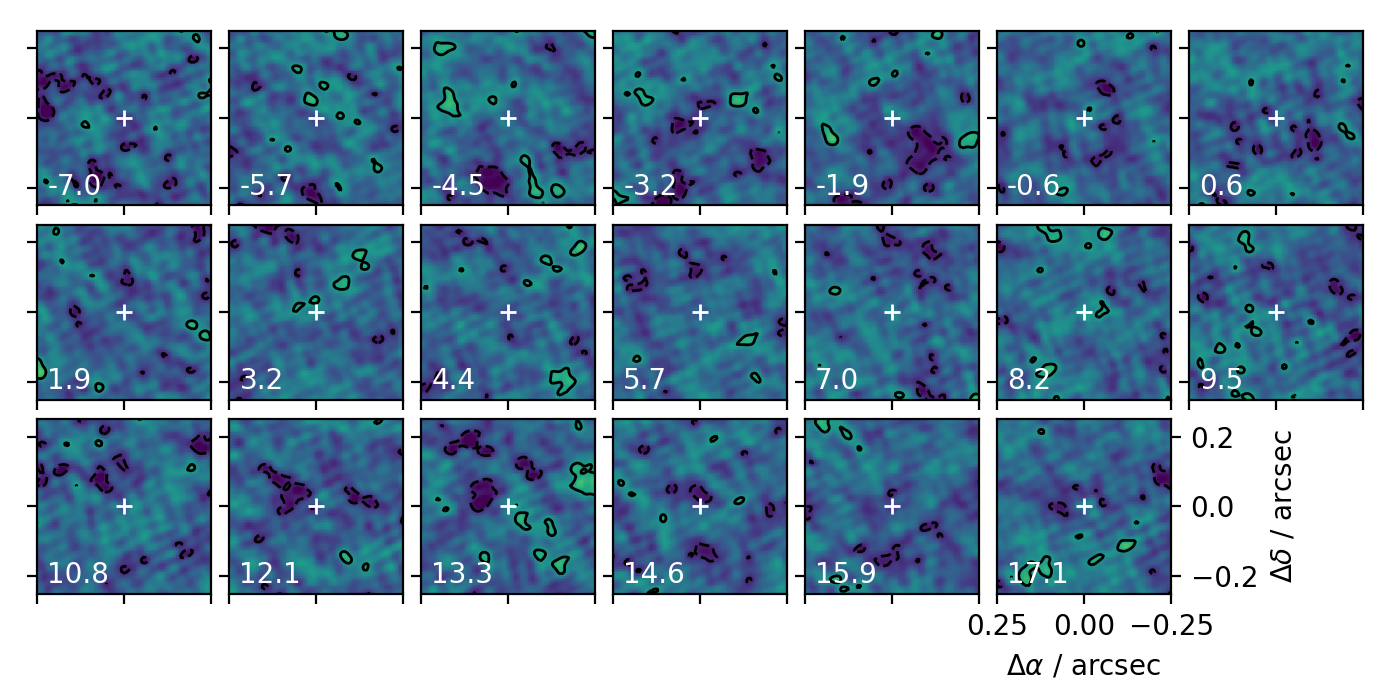

In [85]:
c = resid
# c = cube

x = slice(465,595)
y = slice(575,705)
# x0 = x0_pix - x.start
# y0 = y0_pix - y.start
extent = [ -(x.start-x0_pix)*aspp, (x0_pix-x.stop)*aspp,
          -(y0_pix-y.start)*aspp, (y.stop-y0_pix)*aspp]

# look most of the data
nx = 7
ny = 3
fig = plt.figure(figsize=(nx,ny+0.5))
for i in range(nx):
    for j in range(ny):
        k = i*ny+j
        if k < c.shape[-1]:
            a = fig.add_subplot(ny,nx,k+1)#, projection=w2)
            a.imshow(c[y,x,k], origin='bottom', vmax=0.004, vmin=-0.002, extent=extent)
            a.contour(c[y,x,k], levels=std*np.array([-2,2,4,6]), colors='black', linewidths=1, extent=extent)
            a.plot(0, 0, '+', color='w')
            a.text(0.22,-0.22, '{:3.1f}'.format(rv[k]), color='w')
            a.set_aspect('equal')
            a.set_xlim(0.25,-0.25)
            a.set_ylim(-0.25,0.25)
            if k != 19:
                a.get_xaxis().set_ticklabels([])
                a.get_yaxis().set_ticklabels([])
            else:
                a.set_xlabel('$\\Delta \\alpha$ / arcsec')
                a.set_ylabel('$\\Delta \\delta$ / arcsec')
                a.yaxis.set_label_position('right')
                a.yaxis.set_ticks_position('right')
            
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)

fig.savefig('/Users/grant/astro/doc/hd98800/figs/rv_cube-channels-resid.pdf')

<IPython.core.display.Javascript object>


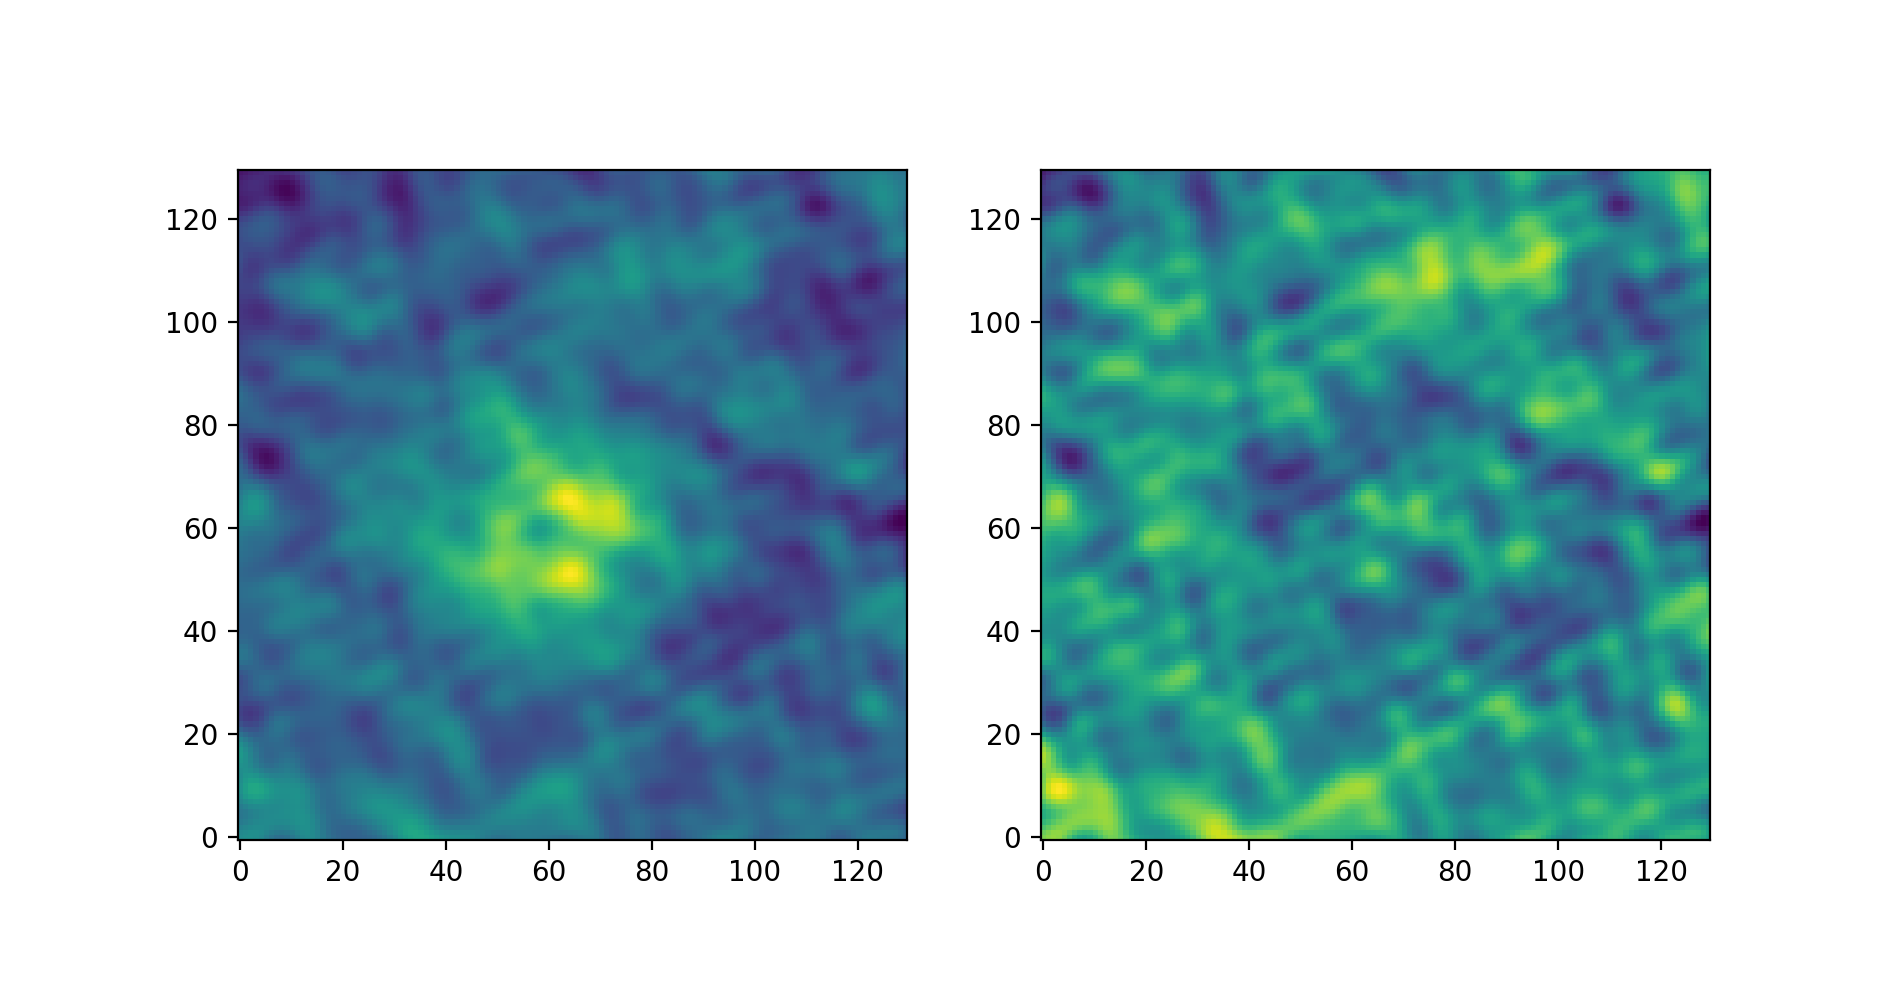

In [27]:
fig,ax = plt.subplots(1,2, figsize=(9.5,5))
ax[0].imshow(np.sum(cube[y,x,:],axis=2), origin='bottom')
ax[1].imshow(np.sum(resid[y,x,:],axis=2), origin='bottom')

# Look empirically at the CO line

In [32]:
data = '/Users/grant/astro/data/alma/hd98800-b6/hd98800.pcal1.CO.natural.fits'

# get some header info
h = fits.open(data)[0]
cube = fits.getdata(data)
cube = np.moveaxis(cube.squeeze(), 0, -1)
cube = np.flip(cube, axis=2)

rv = h.header['CRVAL3'] + np.arange(cube.shape[2])*h.header['CDELT3']
rv = np.flip(rv, axis=0) / 1e3

<IPython.core.display.Javascript object>


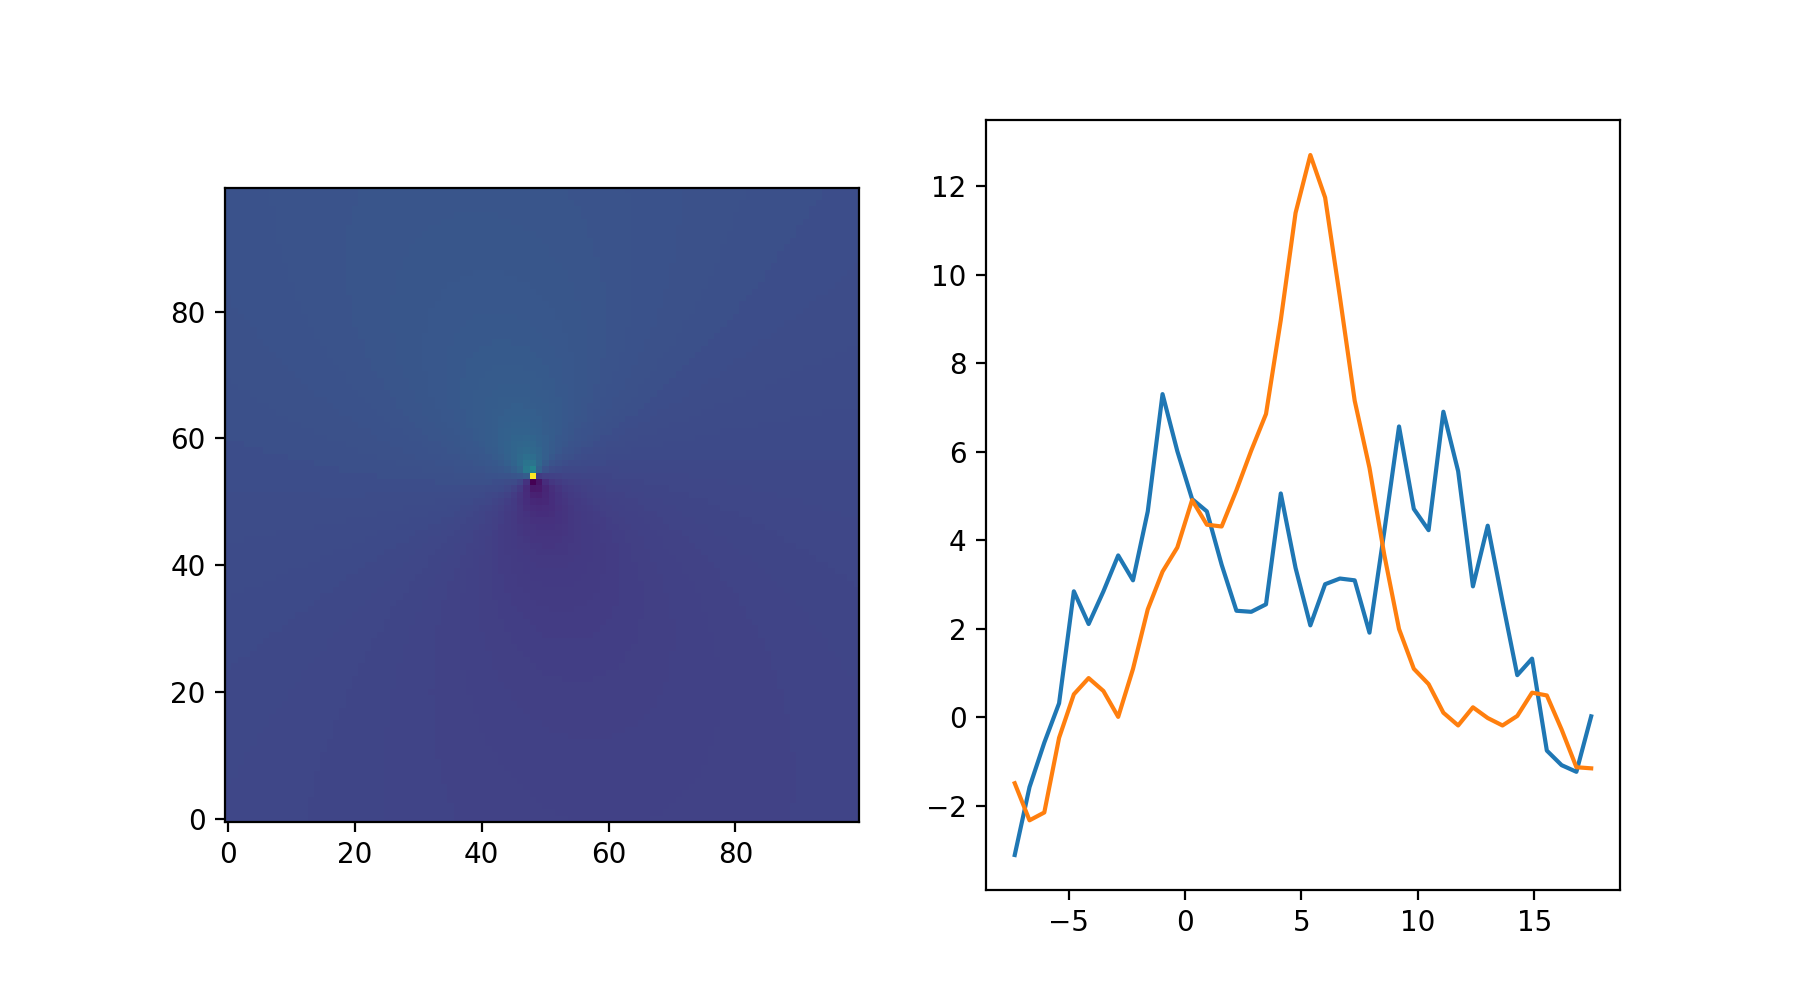

In [37]:
# the parameters from the best-fit continuum model
fit = [17.0, 26.]

data = '/Users/grant/astro/data/alma/hd98800-b6/hd98800.pcal1.CO.approx_center.natural.fits'
c = fits.getdata(data)
c = np.moveaxis(c.squeeze(), 0, -1)
c = np.flip(c, axis=2)

shift, c2 = alma.cube.stack_vel(c, inclination=fit[1], pa=fit[0],
                                x0=-7.59159213e-03, y0=2.23480737e-02,
                                arcsec_pix=aspp, distance=44.9, mstar=1.28,
                                vel_pix=np.diff(rv)[0])

fig,ax = plt.subplots(1,2,figsize=(9,5))
ax[0].imshow(shift, origin='bottom')
ax[1].plot(rv, np.sum(c,axis=(0,1)))
ax[1].plot(rv, np.sum(c2,axis=(0,1)))

<IPython.core.display.Javascript object>


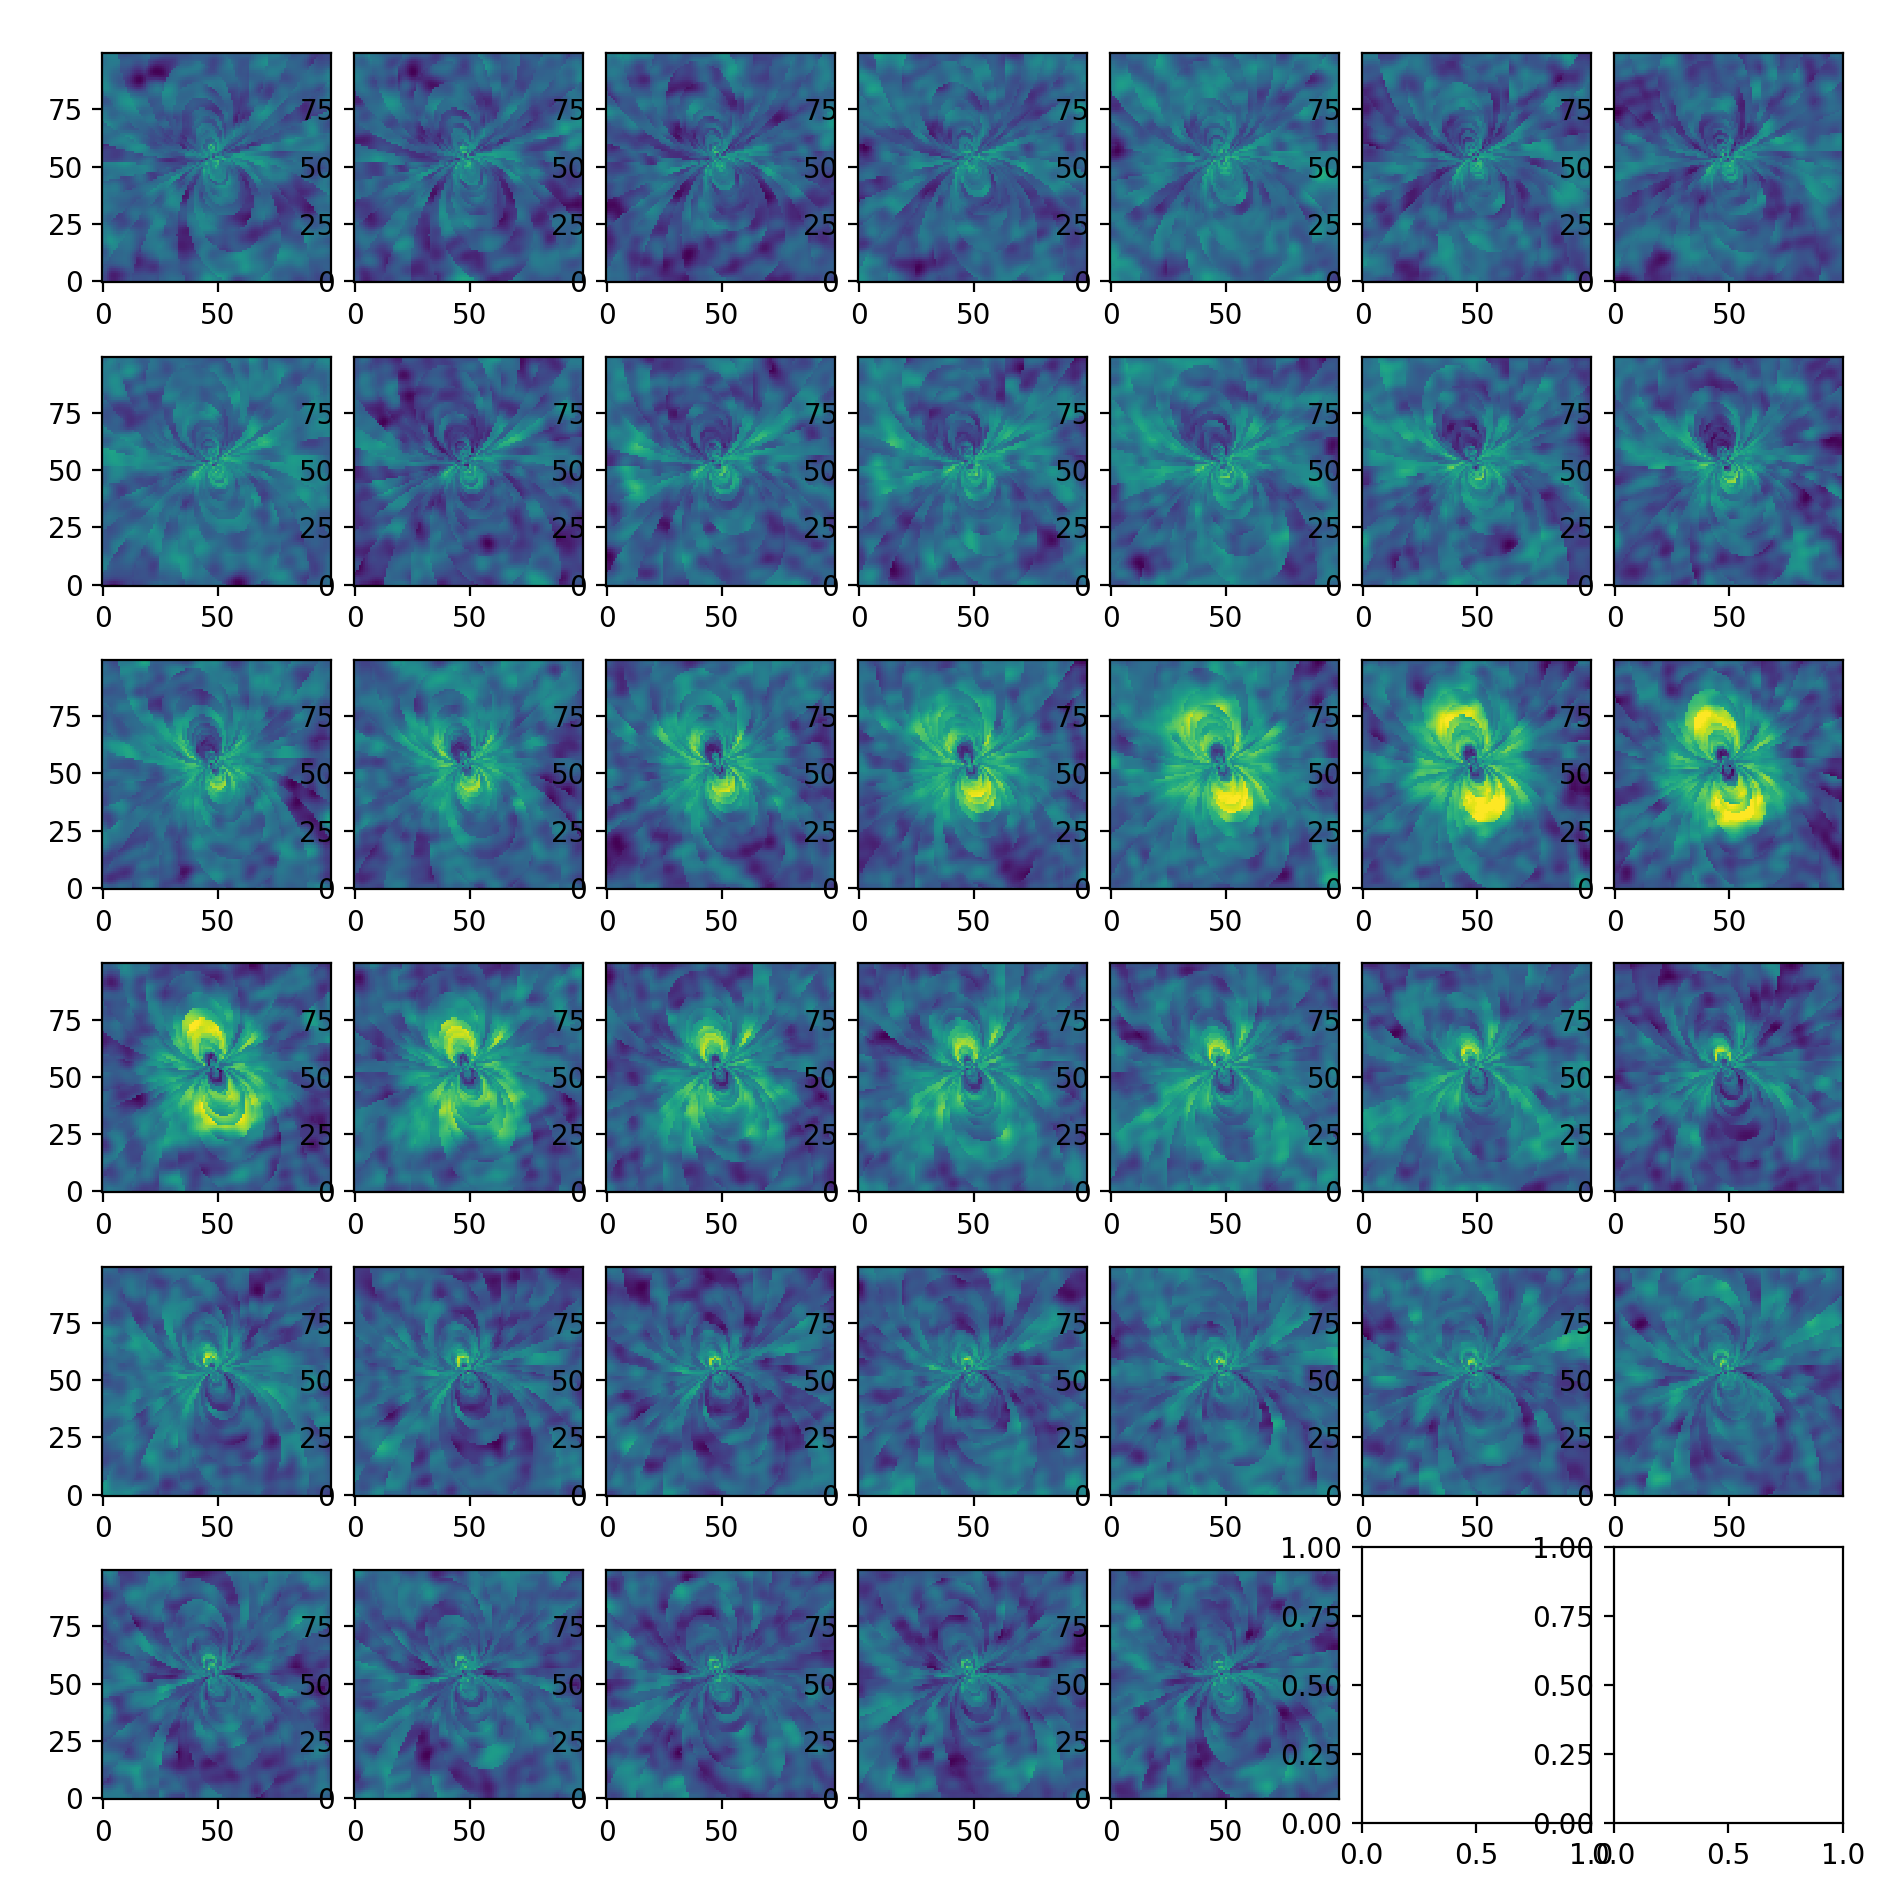

In [38]:
# look at what we cut out
fig,ax = plt.subplots(6, 7, figsize=(9.5,9.5))
for i,a1 in enumerate(ax):
    for j,a in enumerate(a1):
        k = i*len(a1)+j
        if k < c.shape[-1]:
            a.imshow(c2[:,:,k], origin='bottom', vmax=0.006)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)